# Исследовательский анализ данных сервиса для оплаты поездок на самокатах

In [1]:
# Импортируем данные
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
df = pd.read_csv("kicksharing.csv")

In [2]:
# Выведем перавые пять строк 
df.head(10)

,order_rk,party_rk,gender_cd,age,education_level_cd,marital_status_cd,lvn_state_nm,minute_cost,activation_cost,hold_amount,transport_model,distance_km,created_dttm,book_start_dttm,book_end_dttm,book_time_zone_cd,local_book_start_dttm,nominal_price_rub_amt,loyalty_accrual_rub_amt,loyalty_accrual_bns_amt
0,266071307,761067705,M,40,UGR,DIV,ТЮМЕНСКАЯ ОБЛ,4.99,30.0,300.0,SL,3.690479,2024-08-07 09:47:25.000000,2024-08-07 09:47:29.325252,2024-08-07 10:07:59.339524,5,2024-08-07 11:47:29.325252,134.79,19.48,NaN
1,355113920,614049469,F,30,GRD,MAR,РОСТОВСКАЯ ОБЛ,8.49,50.0,300.0,SL,1.114912,2024-10-17 14:57:20.000000,2024-10-17 14:57:24.586000,2024-10-17 15:04:19.419607,3,2024-10-17 14:57:24.586000,109.43,40.30,NaN
2,347424551,757583701,M,28,UGR,UNM,СВЕРДЛОВСКАЯ ОБЛ,5.99,30.0,300.0,E,1.515612,2024-09-19 05:31:41.000000,2024-09-19 05:34:59.476000,2024-09-19 05:41:50.164372,5,2024-09-19 07:34:59.476000,71.93,10.79,NaN
3,351562959,541367366,M,24,GRD,UNM,Г МОСКВА,8.99,50.0,300.0,SL,0.499411,2024-10-04 16:05:09.000000,2024-10-04 16:05:13.162000,2024-10-04 16:07:31.724918,3,2024-10-04 16:05:13.162000,76.97,7.70,NaN
4,258647149,238473615,M,34,NaN,NaN,Г МОСКВА,6.99,50.0,300.0,SL,2.602028,2024-07-10 06:57:40.000000,2024-07-10 06:57:43.017125,2024-07-10 07:07:48.446462,3,2024-07-10 06:57:43.017125,126.89,25.38,NaN
5,277397094,5247768,M,42,NaN,NaN,МОСКВА,7.49,50.0,300.0,SL,0.016090,2024-09-10 09:40:18.000000,2024-09-10 09:40:24.036000,2024-09-10 09:41:03.644495,3,2024-09-10 09:40:24.036000,0.00,NaN,NaN
6,273528957,801272780,F,19,NaN,NaN,РЕСП ТАТАРСТАН,7.49,30.0,300.0,SL,4.086853,2024-09-03 14:10:29.000000,2024-09-03 14:10:34.524349,2024-09-03 14:21:25.119585,3,2024-09-03 14:10:34.524349,112.39,28.00,NaN
7,265062394,866880584,M,38,NaN,NaN,СВЕРДЛОВСКАЯ ОБЛ,5.99,30.0,300.0,E,2.370597,2024-08-03 03:09:35.000000,2024-08-03 03:09:38.493851,2024-08-03 03:18:47.841493,5,2024-08-03 05:09:38.493851,89.90,12.99,NaN
8,351562880,762053500,M,19,NaN,NaN,НОВОСИБИРСКАЯ ОБЛ,5.99,30.0,300.0,E,0.101272,2024-10-04 10:45:16.000000,2024-10-04 10:45:20.457000,2024-10-04 10:47:39.863967,7,2024-10-04 14:45:20.457000,47.97,4.80,NaN
9,269365210,161703813,M,31,UGR,MAR,ЧЕЛЯБИНСКАЯ ОБЛ,6.49,30.0,300.0,E,1.487792,2024-08-19 14:35:17.000000,2024-08-19 14:35:20.199325,2024-08-19 14:42:53.835731,5,2024-08-19 16:35:20.199325,81.92,81.92,NaN


## 1 ЧАСТЬ: Предобработка данных

### Проверка пропусков

In [3]:
print(df.isna().sum().sort_values(ascending = False) / df.shape[0])

loyalty_accrual_bns_amt    0.944680
education_level_cd         0.520959
marital_status_cd          0.451217
lvn_state_nm               0.086143
loyalty_accrual_rub_amt    0.075002
gender_cd                  0.007362
created_dttm               0.000000
nominal_price_rub_amt      0.000000
local_book_start_dttm      0.000000
book_time_zone_cd          0.000000
book_end_dttm              0.000000
book_start_dttm            0.000000
order_rk                   0.000000
distance_km                0.000000
party_rk                   0.000000
hold_amount                0.000000
activation_cost            0.000000
minute_cost                0.000000
age                        0.000000
transport_model            0.000000
dtype: float64


**MAR (Missing At Random)**
- education_level_cd (52%) — не все пользователи указывают образование; зависит от заполненности профиля.
- marital_status_cd (45%) — часть клиентов не делится семейным статусом.
- lvn_state_nm (8%) — отсутствие региона может зависеть от канала регистрации или паттерна использования приложения.
- gender_cd (0.7%) — редкие пропуски, чаще всего вместе с другими пустыми анкетными полями.
- loyalty_accrual_rub_amt (7.5%) — пусто, если оплата не предполагала, например, поездка была сразу же отменена после начала из-за неисправности самоката или по другой причине.

**MNAR (Missing Not At Random)**
- loyalty_accrual_bns_amt (94%) — начисляется только при оплате кредитной картой, отсутствие значения отражает, что пользователь не имеет кредитки или не платит с нее при поездках на самокате.
- Соц.-демографические поля (образование, семейное положение) частично MNAR, если пропуск вызван нежеланием пользователя делиться данными.

**Итого**
- Пропуски в таких категориальных признаках как образование, семейный статус, пол, регион следует заменить на “Не указано”.
- В информации о кэшбэке следует заменить пропуски на 0.

In [4]:
df['education_level_cd'] = df['education_level_cd'].fillna('Не указано')
df['marital_status_cd'] = df['marital_status_cd'].fillna('Не указано')
df['gender_cd'] = df['gender_cd'].fillna('Не указано')
df['lvn_state_nm'] = df['lvn_state_nm'].fillna('Не указано')

df['loyalty_accrual_rub_amt'] = df['loyalty_accrual_rub_amt'].fillna(0)
df['loyalty_accrual_bns_amt'] = df['loyalty_accrual_bns_amt'].fillna(0)

### Проверка типов данных

In [5]:
# Выведем типы данных
df.dtypes

order_rk                     int64
party_rk                     int64
gender_cd                   object
age                          int64
education_level_cd          object
marital_status_cd           object
lvn_state_nm                object
minute_cost                float64
activation_cost            float64
hold_amount                float64
transport_model             object
distance_km                float64
created_dttm                object
book_start_dttm             object
book_end_dttm               object
book_time_zone_cd            int64
local_book_start_dttm       object
nominal_price_rub_amt      float64
loyalty_accrual_rub_amt    float64
loyalty_accrual_bns_amt    float64
dtype: object

1. **Числовые (int/float)**
    - `order_rk`, `party_rk`, `age` — целочисленные идентификаторы и возраст.  
    - `minute_cost`, `activation_cost`, `hold_amount`, `distance_km`, `nominal_price_rub_amt`, `loyalty_accrual_rub_amt`, `loyalty_accrual_bns_amt` — денежные показатели и метрики поездки, представлены как `float64`.
2. **Категориальные (object)**
    - `gender_cd`, `education_level_cd`, `marital_status_cd`, `lvn_state_nm`, `transport_model` — категориальные признаки, в дальнейшем стоит перевести в `category` для оптимизации.
3. **Дата и время (object)**
    - `created_dttm`, `book_start_dttm`, `book_end_dttm`, `local_book_start_dttm` — пока в формате `object`, нужно привести к `datetime`.  
    - `book_time_zone_cd` — числовой код часового пояса, сейчас `int64`.


In [6]:
# Сделаем замену типов данных
date_cols = ['created_dttm','book_start_dttm','book_end_dttm','local_book_start_dttm']
cat_cols = ['gender_cd','education_level_cd','marital_status_cd','lvn_state_nm','transport_model']

for c in date_cols:
    df[c] = pd.to_datetime(df[c], errors='coerce')

df[cat_cols] = df[cat_cols].astype('category')

In [7]:
# Првоерим замену
df.dtypes

order_rk                            int64
party_rk                            int64
gender_cd                        category
age                                 int64
education_level_cd               category
marital_status_cd                category
lvn_state_nm                     category
minute_cost                       float64
activation_cost                   float64
hold_amount                       float64
transport_model                  category
distance_km                       float64
created_dttm               datetime64[ns]
book_start_dttm            datetime64[ns]
book_end_dttm              datetime64[ns]
book_time_zone_cd                   int64
local_book_start_dttm      datetime64[ns]
nominal_price_rub_amt             float64
loyalty_accrual_rub_amt           float64
loyalty_accrual_bns_amt           float64
dtype: object

### Проверка дубликатов

In [8]:
# Проверим на явные и неявные дубликаты
print("Количество явных дубликатов:", df.duplicated().sum())
print("Дубликатов по order_rk:", df.duplicated(subset=['order_rk']).sum())

Количество явных дубликатов: 0
Дубликатов по order_rk: 0


In [9]:
# Ещё проверим на неявные дуликаты
dup_candidates = (
    df.groupby(['party_rk','book_start_dttm','book_end_dttm','distance_km','nominal_price_rub_amt'])
      .size()
      .reset_index(name='count')
      .query('count > 1')
)

print("Количество потенциальных дублей:", dup_candidates.shape[0])
display(dup_candidates.head())

Количество потенциальных дублей: 0


,party_rk,book_start_dttm,book_end_dttm,distance_km,nominal_price_rub_amt,count


- Каждая строка соответствует уникальной поездке, полных совпадений или ошибок при загрузке данных не обнаружено.  

### Проверка аномальных значений

In [10]:
# Посмотрим на аномальные значения, которые могли произойти из-за сбоя в системе, а может из-за поломок в самокатах
df['trip_duration_min'] = (df['book_end_dttm'] - df['book_start_dttm']).dt.total_seconds() / 60
df[['trip_duration_min','distance_km','nominal_price_rub_amt','age']].describe(percentiles=[0.01,0.05,0.95,0.99])

,trip_duration_min,distance_km,nominal_price_rub_amt,age
count,396749.000000,396749.000000,396749.000000,396749.000000
mean,11.440989,3.681031,127.647694,31.544006
std,13.174834,141.862349,100.122365,9.434545
min,0.033400,0.000000,0.000000,12.000000
1%,0.650279,0.000000,0.000000,18.000000
5%,1.963396,0.024576,47.970000,19.000000
50%,7.768650,1.729883,103.940000,31.000000
95%,32.072975,7.083801,284.660000,48.000000
99%,64.193356,13.723404,526.470000,60.000000
max,715.172206,56012.640308,5627.640000,94.000000


trip_duration_min           Axes(0.125,0.11;0.168478x0.77)
distance_km              Axes(0.327174,0.11;0.168478x0.77)
nominal_price_rub_amt    Axes(0.529348,0.11;0.168478x0.77)
age                      Axes(0.731522,0.11;0.168478x0.77)
dtype: object

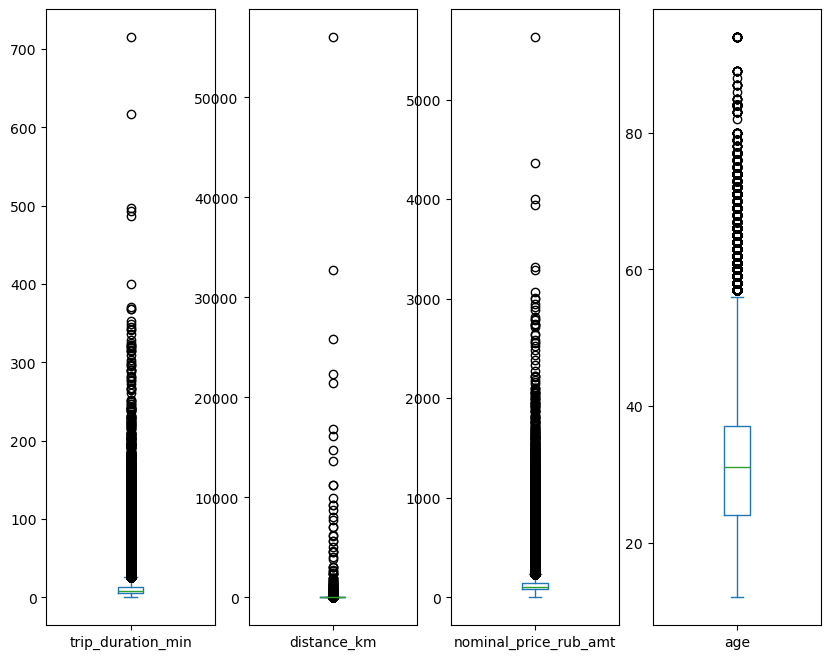

In [11]:
df[['trip_duration_min','distance_km','nominal_price_rub_amt','age']].plot(kind='box', subplots=True, figsize=(10,8))

In [12]:
num_cols = ['trip_duration_min','distance_km','nominal_price_rub_amt','age']

# Рассчитав межквартильный размах, можем выбросить выборсы
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    before = df.shape[0]
    df = df[(df[col] >= lower) & (df[col] <= upper)]
    after = df.shape[0]
    print(f"{col}: удалено {before - after} строк")

trip_duration_min: удалено 30569 строк
distance_km: удалено 17147 строк
nominal_price_rub_amt: удалено 20492 строк
age: удалено 4546 строк


- Для числовых признаков (`trip_duration_min`, `distance_km`, `nominal_price_rub_amt`, `age`) применён метод межквартильного размаха (IQR).  
- Исключены наблюдения, выходящие за границы `[Q1 - 1.5*IQR ; Q3 + 1.5*IQR]`.  
- В результате удалены аномальные значения:
  - слишком короткие или чрезмерно длинные поездки по времени;  
  - нулевые и нереалистично большие дистанции;  
  - поездки с аномально низкой или высокой стоимостью;  
  - нереалистичные значения возраста.  

---

1. **Пропуски**  
    - Категориальные признаки (`education_level_cd`, `marital_status_cd`, `gender_cd`, `lvn_state_nm`) дополнены категорией *"Не указано"*.  
    - Финансовые показатели кэшбэка (`loyalty_accrual_rub_amt`, `loyalty_accrual_bns_amt`) заполнены нулями, что отражает отсутствие начислений.  
2. **Типы данных**  
    - Датовые поля приведены к типу `datetime`.
    - Категориальные признаки переведены в формат `category` для оптимизации.
    - Числовые поля оставлены без изменений, так как типы корректные.  
3. **Дубликаты**
    - Явных дубликатов строк не обнаружено.
    - Дубликатов по ключу `order_rk` нет.
5. **Аномальные значения**
    - Для числовых признаков (`trip_duration_min`, `distance_km`, `nominal_price_rub_amt`, `age`) применён метод межквартильного размаха (IQR).  
    - Исключены записи с экстремальными значениями:
    - слишком короткие или чрезмерно длинные поездки;
    - нулевые и нереалистично большие дистанции;
    - некорректные значения стоимости;
    - аномальные значения возраста.  

#### Датасет очищен от пропусков и приведён к корректным типам. Можно переходить к исследовательскому анализу данных (EDA).

## 2 ЧАСЬ: Исследовательский анализ данных

### Пространственно-временные характеристики поездок

#### Какова "сезонность" исольхования приложения в течении недели? Суток?

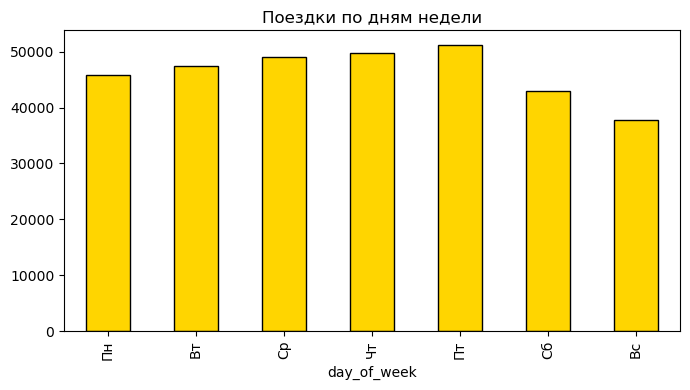

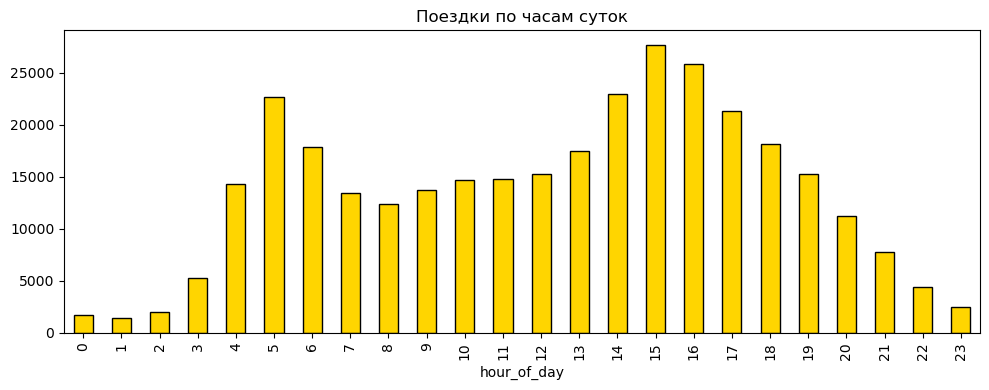

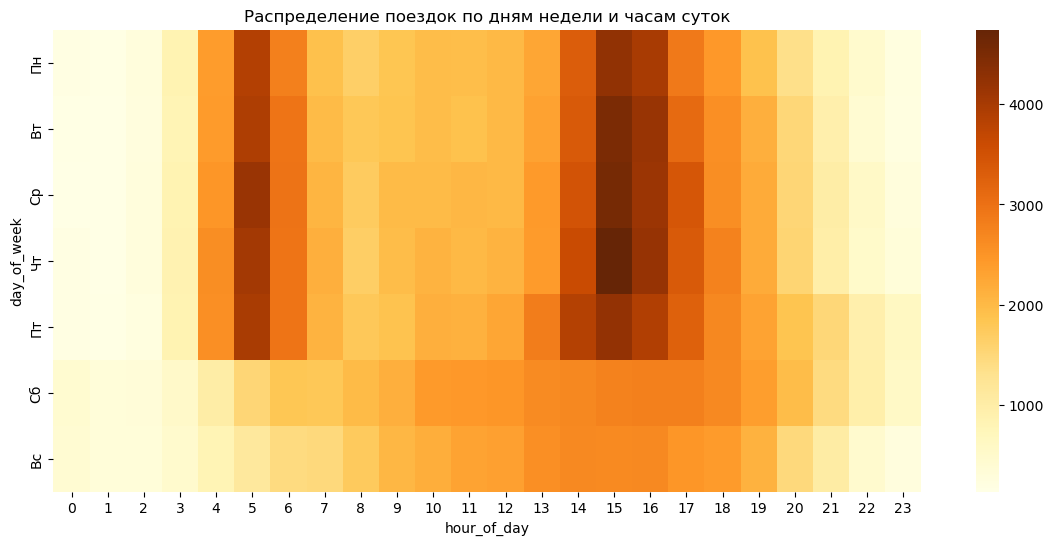

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

df['day_of_week'] = df['local_book_start_dttm'].dt.dayofweek.map({0:'Пн',1:'Вт',2:'Ср',3:'Чт',4:'Пт',5:'Сб',6:'Вс'})
df['hour_of_day'] = df['local_book_start_dttm'].dt.hour

# По дням недели
dow_counts = df['day_of_week'].value_counts().reindex(['Пн','Вт','Ср','Чт','Пт','Сб','Вс'])
ax = dow_counts.plot(kind='bar', figsize=(7,4), color="#FFD500", edgecolor="black")
ax.set_title("Поездки по дням недели")
plt.tight_layout()
plt.show()

# По часам суток
hr_counts = df['hour_of_day'].value_counts().sort_index()
ax = hr_counts.plot(kind='bar', figsize=(10,4), color="#FFD500", edgecolor="black")
ax.set_title("Поездки по часам суток")
plt.tight_layout()
plt.show()

# Тепловая карта день × час
pivot = df.groupby(['day_of_week','hour_of_day']).size().unstack(fill_value=0).reindex(['Пн','Вт','Ср','Чт','Пт','Сб','Вс'])
plt.figure(figsize=(14,6))
sns.heatmap(pivot, cmap="YlOrBr")
plt.title("Распределение поездок по дням недели и часам суток")
plt.show()

- В будние дни наблюдается два активных промежутка времени: до и после работы, расстояние между эими полосками, как можно видеть на тепловой карте как раз 8 часов (продолжительность рабочего дня), что подтверждает предположение о том, что наибольшим спросом СИМы пользуются при поездках пользователей на работу и с работы;
- В тоже есть загрузка, но здесь поездки носят, скорее всего, досуговый характер: люди ездят в ТЦ, парки и пр. места для отдыха, поэтому нет таких ярко выраженных "линий" спроса, как в будние дни.

#### Сколько минут, в среднем, пользователь тратит на поездку?

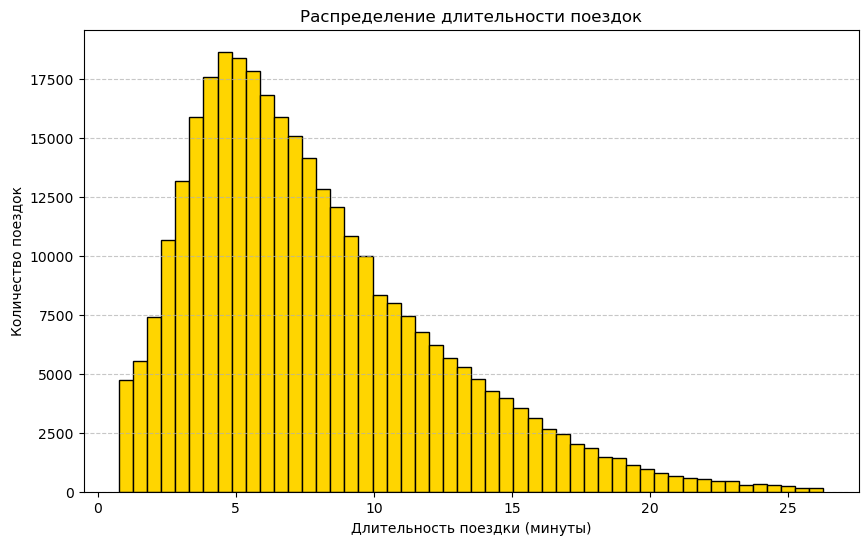

In [14]:
plt.figure(figsize=(10,6))
plt.hist(df['trip_duration_min'], bins=50, color="#FFD500", edgecolor="black")
plt.title("Распределение длительности поездок")
plt.xlabel("Длительность поездки (минуты)")
plt.ylabel("Количество поездок")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [15]:
df['trip_duration_min'].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

count    323995.000000
mean          7.825628
std           4.475116
min           0.764181
1%            1.133709
5%            2.206945
25%           4.501049
50%           6.867767
75%          10.269825
95%          16.601911
99%          21.359240
max          26.279885
Name: trip_duration_min, dtype: float64

- Как и следовало ожидать, в большинстве случаев поездка не превышает и 10 минут (**3 куантиль**), поэтому распределение имеет вытянутый правый "хвост" им аксимальная продолжительность поездки принимает чуть больше 26 минут;
- Данная информация может нам потребоваться, когда мы будем анализировать продолжительность поездки по разлиичным сегментам, например, у женщин эта характеристика может быть выше, потому что они чаще ездят на самокатах с целью получить от поездки удовольстие или, например, эта характеристика может быть связана со стоимостью поездки, что весмьа вероятно, если люди в большинстве случаев предпочитают не растягивать поездку, зная, что одна минута стоит достаточно дорого.

#### Сколько в среднем проезжает пользователь?

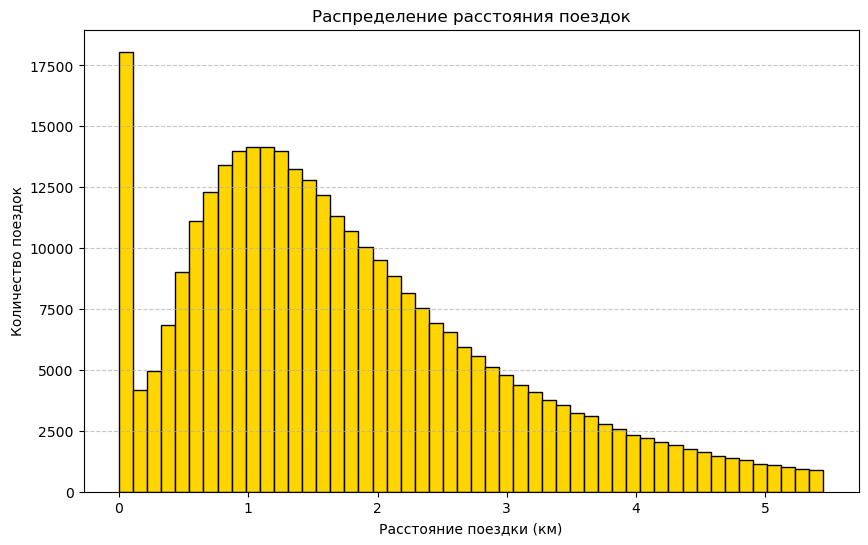

In [16]:
# Построим гистограму распределения протяжённости поездок
plt.figure(figsize=(10,6))
plt.hist(df['distance_km'], bins=50, color="#FFD500", edgecolor="black")
plt.title("Распределение расстояния поездок")
plt.xlabel("Расстояние поездки (км)")
plt.ylabel("Количество поездок")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [17]:
df['distance_km'].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

count    323995.000000
mean          1.757716
std           1.192509
min           0.000000
1%            0.000000
5%            0.068176
25%           0.880207
50%           1.523132
75%           2.436470
95%           4.162278
99%           5.085672
max           5.448101
Name: distance_km, dtype: float64

- Большинство поездок не превышают 2,5 км (**3ий куантиль**). Скорее всего, большинство людей использует самокат в первую очередь для того, чтобы добраться до точки интереса, как и было сказано ранее, Point of interest. Это либо остановка общественного транспорта (на данном фоне особенно выделяется **1ый куантиль - меньше киллометра!**), либо место учёбы/работы/досуга. 

### Модели самокатов и первоначальные взносы 

- В этом разделе мы посмотрим, какими самокатами пользуются в болььшинстве поездок, а также изучим, подтвердим предположение, что стоимость взноса зависит именно от модели самоката, а не от прочих переменных, уникальных для каждого пользователя. 

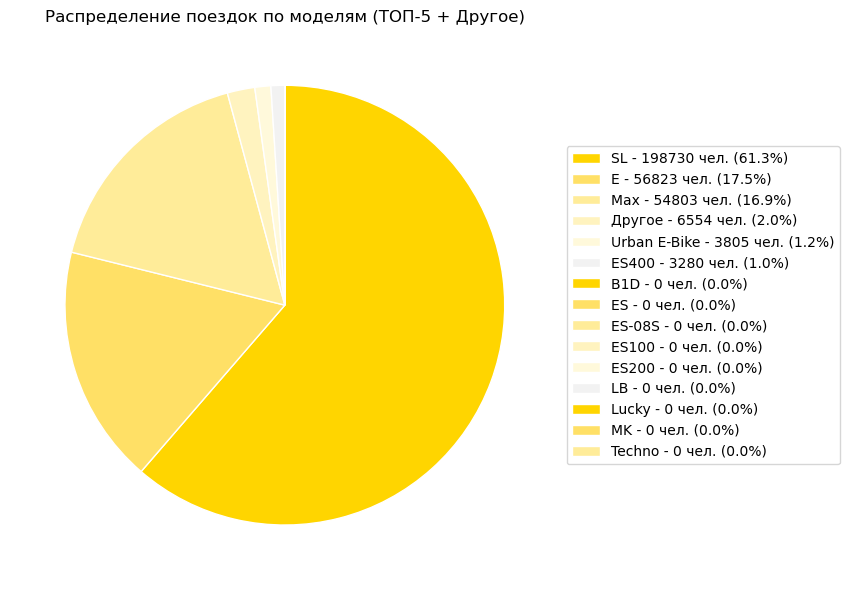

In [18]:
top_n = 5
top_models = df['transport_model'].value_counts().nlargest(top_n).index

df['transport_model'] = df['transport_model'].cat.add_categories(['Другое'])
df['transport_model_grouped'] = df['transport_model'].where(df['transport_model'].isin(top_models), 'Другое')

counts = df['transport_model_grouped'].value_counts()
shares = (counts / counts.sum() * 100).round(1)

# Подписи для легенды: Модель - X чел. (Y%)
labels = [f"{name} - {cnt} чел. ({pct}%)" for name, cnt, pct in zip(counts.index, counts.values, shares)]

plt.figure(figsize=(8,6))
plt.pie(
    counts.values,
    colors=['#FFD500','#FFE066','#FFEC99','#FFF3BF','#FFF9DB','#F2F2F2'],
    startangle=90,
    counterclock=False,
    wedgeprops=dict(edgecolor='white', linewidth=1)
)

plt.title(f"Распределение поездок по моделям (ТОП-{top_n} + Другое)")
plt.legend(labels, loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()


- Можно видеть, что больше половины поездок в сзоне были сделаны на самокатах модели SL. Пока это нам ни о чем не говорит, но в дальнешем это нам может пригодиться, так как именно от того, какими самокатами пользуется человек, зависят его впечатления от поездки. Для новых пользователей это очень важно, так как напрямую влияет на то, продолжат ли они пользоваться сервисом или нет (Retention Rate).

In [19]:
df[['transport_model', 'hold_amount']].drop_duplicates().sort_values(['transport_model','hold_amount'])

,transport_model,hold_amount
45257,B1D,300.0
2,E,300.0
60,ES,300.0
1369,ES-08S,300.0
414,ES100,300.0
150392,ES100,500.0
95,ES200,300.0
216,ES400,300.0
1549,LB,300.0
23277,Lucky,80.0


- Здесь видно, что величина взноса напрямую зависит от того, какой линейкой самокатов пользуется ездок. Так, самая высокая начальная плата к ES100 после индексациии цен, **целые 500 рублей** замораживаются на счету пользователя перед началом поездки, что может оказывать существенное влияние на принятие им решение, брать ли в аренду кикшеринг или нет;
- Для самой популярной модели самокатов данный показетль средний - **300 рублей** и индексации не было;
- В целом, для вес моделей, которые распространены среди пользователей данный показатель принимает одинаковое значение - 300 рубелй.

### Социально-демографические характеристики пользователей

#### В каком возрасте чаще всего используют сервис аренды самокатов в Т-банке?

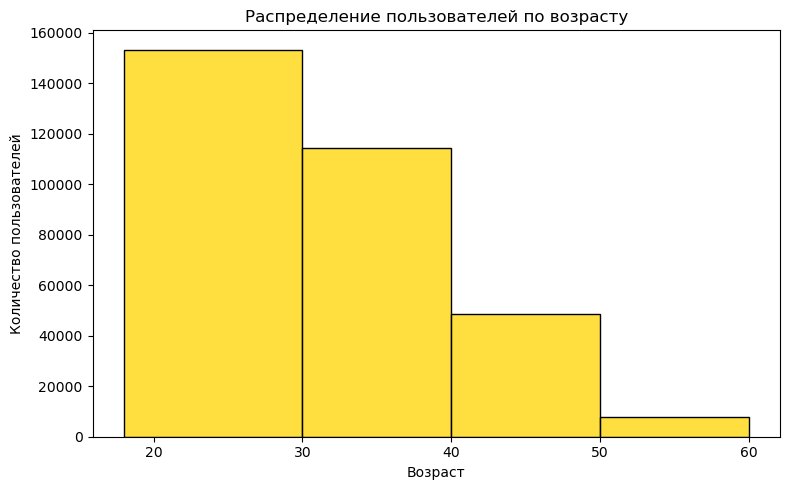

,count,share_%
age_group,,
18–29,153205,47.3
30–39,114460,35.3
40–49,48424,14.9
50+,7877,2.4


In [26]:
# Кастомные бины и подписи
bins   = [18, 30, 40, 50, 60]
labels = ['18–29', '30–39', '40–49', '50+']

# Гистограмма по тем же бинам
plt.figure(figsize=(8,5))
sns.histplot(df.loc[df['age'] >= 18, 'age'], bins=bins, kde=False,
             color="#FFD500", edgecolor="black")
plt.title("Распределение пользователей по возрасту")
plt.xlabel("Возраст")
plt.ylabel("Количество пользователей")
plt.tight_layout()
plt.show()

# Группировка по бинам и доли
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)  # 18 включительно, 30 невключительно
age_group_counts = df['age_group'].value_counts().sort_index()
age_group_shares = (age_group_counts / age_group_counts.sum() * 100).round(1)

display(pd.DataFrame({'count': age_group_counts, 'share_%': age_group_shares}))

- Большая часть клиентов (**больше 75%**) в возрасте **от 18 до 40 лет**, что неудивительно, потому что использование кишеринга имеет строгое ограничение от 18 лет, а старшая аудитория в большинстве своём относится к нему скептически из-за сомнений в его безопасности или не использует его, потому что уже располагает личным авто;
- Аудитории старше 60 лет не осталось после того, как мы почистили наши данные от выбросов. 

#### Какого пола, преимущественно пользователи? Какое у них семейное положение? Образование?

In [21]:
# Здесь я просто делаю расшифровки для лучшей читаемости

# Пол
gender_map = {
    "M": "Мужчины",
    "F": "Женщины",
    "Не указано": "Не указано"
}

# Образование
edu_map = {
    "SCH": "Начальное, среднее",
    "GRD": "Высшее",
    "UGR": "Неполное высшее",
    "PGR": "Два высших",
    "ACD": "Учёная степень",
    "Не указано": "Не указано"
}

# Семейный статус
marital_map = {
    "IMR": "Незарегистрированный брак",
    "MAR": "Женат/Замужем",
    "DLW": "Не проживает с супругом(ой)",
    "OMR": "Зарегистрированный брак",
    "CIV": "Гражданский брак",
    "UNM": "Холост/Не замужем",
    "DIV": "Разведён(а)",
    "FAL": "Никогда не состоял(а) в браке",
    "WID": "Вдовец/Вдова",
    "Не указано": "Не указано"
}

In [22]:
# Попробую сделать функцию, чтобы автомотизироваь процесс построения круговых диаграмм для демографически характеристик
def plot_pie_with_mapping(series, mapping, title, colors=None):
    mapped = series.map(mapping).fillna("Не указано")
    counts = mapped.value_counts()
    shares = (counts / counts.sum() * 100).round(1)
    labels = [f"{name} - {cnt} чел. ({pct}%)" for name, cnt, pct in zip(counts.index, counts.values, shares)]
    
    plt.figure(figsize=(8,6))
    plt.pie(
        counts.values,
        colors=colors if colors else plt.cm.YlOrBr_r(range(len(counts))),
        startangle=90,
        counterclock=False,
        wedgeprops=dict(edgecolor='white', linewidth=1)
    )
    plt.title(title)
    plt.legend(labels, loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()

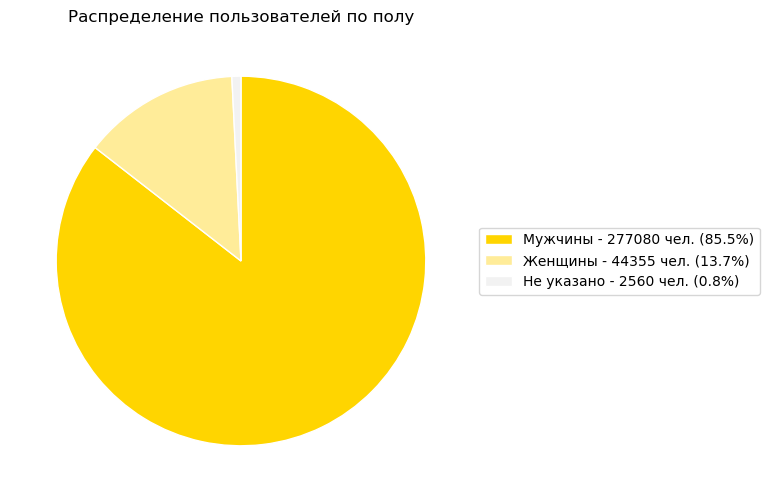

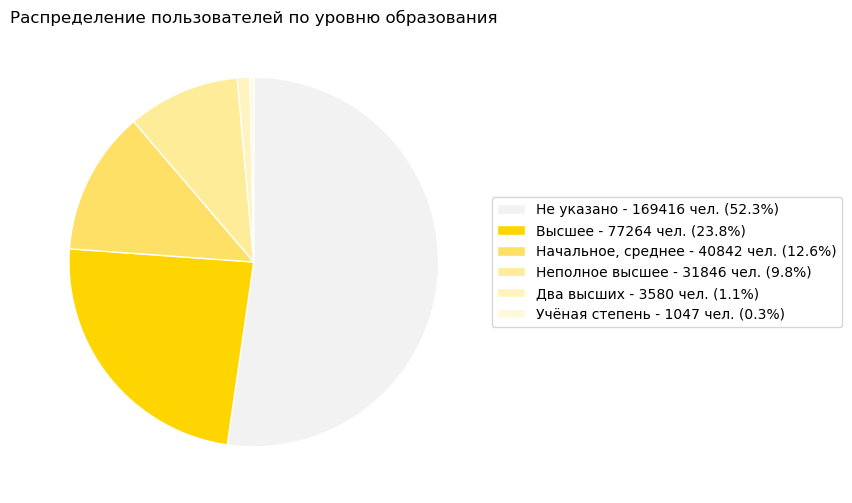

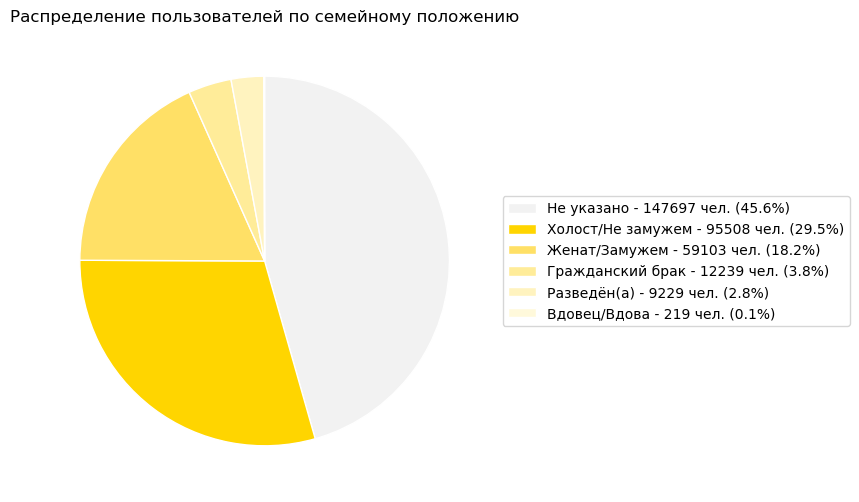

In [23]:
# Пол
plot_pie_with_mapping(df['gender_cd'], 
                      gender_map, 
                      "Распределение пользователей по полу",
                      colors=['#FFD500','#FFEC99','#F2F2F2'])

# Образование
plot_pie_with_mapping(df['education_level_cd'], 
                      edu_map, 
                      "Распределение пользователей по уровню образования",
                      colors=['#F2F2F2', '#FFD500','#FFE066','#FFEC99','#FFF3BF','#FFF9DB'])

# Семейное положение
plot_pie_with_mapping(df['marital_status_cd'], 
                      marital_map, 
                      "Распределение пользователей по семейному положению", 
                      colors=['#F2F2F2', '#FFD500','#FFE066','#FFEC99','#FFF3BF','#FFF9DB'])

- **Больше 85%** пользователей сервиса являются мужчинами и только **13,7%** - женщины, что неудивительно. СИМы являются травмоопасным средством передвижения, поэтому женщины реже используют его в качестве средства передвижения, предпочитая, например, добраться до точки пешком или на такси.
- Больше половины (**52%**) не указали уровень своего образования, но несмотря на это можно заметить, что почти в ччетверти случаев пользователи имеют вышее / неполное высшее образование (**23,8% / 12,6%**) или начальное среднее образование (**12,6%**)
- Четь меньше половины не указали свой семейный статус, но в **29,5%** мы можем видеть, что пользователь не в браке, а в **18,2%**, что находится в браке. Пока сложно, сказать, как применить данную информацию, но возможно, это может влиять на, например, количество поездок за счёт того, что люди, которые имеют семью чаще ездят на самокатах, потому что работают, а значит, используют СИМы для преодоления первой и последей мили. 

#### В каких регионах было совершено больше всего поездок за 6 месяццев?

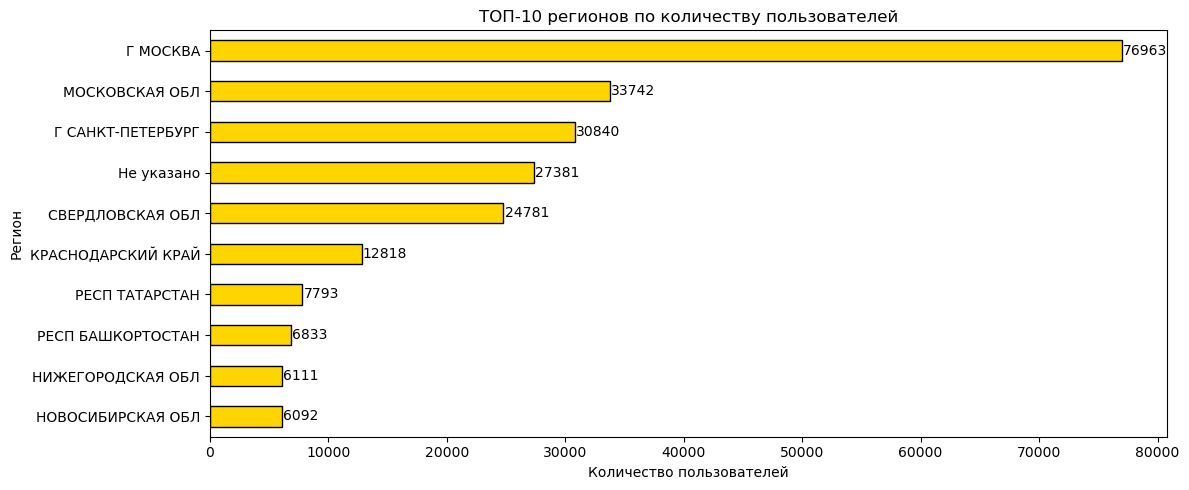

In [24]:
# Подсчёт и сортировака от большего к меньшему
top_regions = df['lvn_state_nm'].value_counts().head(10).sort_values(ascending=True)

# Построение линейчатой деаграммы
plt.figure(figsize=(12,5))
ax = top_regions.plot(kind='barh', color="#FFD500", edgecolor="black")
plt.title("ТОП-10 регионов по количеству пользователей")
plt.xlabel("Количество пользователей")
plt.ylabel("Регион")

# Добавлю подписи значнеий для удобства чтения
for i, v in enumerate(top_regions):
    ax.text(v + 100, i, str(v), va='center')

plt.tight_layout()
plt.show()

- Как и следовало ожидать, рекордсменом по количеству поездок является Москва (**76.963 поездки за 6 месяцев**), второе и третье место занимает Московская область и Санкт-Петербург. 

## 3 ЧАСТЬ: Расчёт и анализ основных продуктовых метрик

### Основными продуктовыми метриками в рамках данного продукта будут выступать: 


### DAU, WAU и MAU

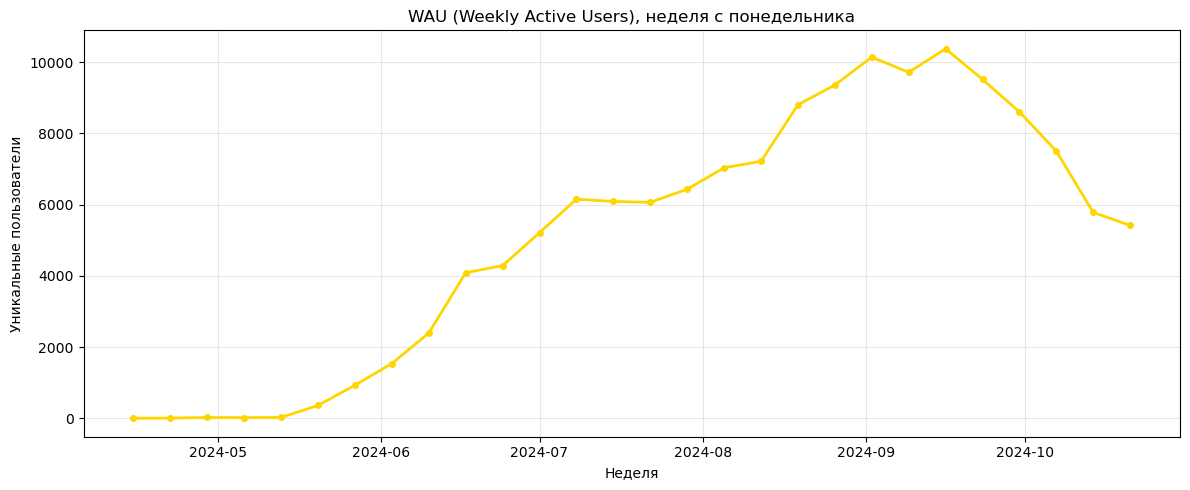

In [29]:
# ---- расчёт WAU (неделя с понедельника)
time_col = next(c for c in ['book_start_dttm','created_dttm','book_end_dttm','order_dttm','dt'] if c in df.columns)
user_col = next(c for c in ['party_rk','party_rk_id','user_id','client_id'] if c in df.columns)

tmp = df[[time_col, user_col]].copy()
tmp[time_col] = pd.to_datetime(tmp[time_col], errors='coerce').dt.tz_localize(None)
wau = (tmp.dropna().set_index(time_col)
          .groupby(pd.Grouper(freq='W-MON'))[user_col]
          .nunique()
          .rename('WAU'))

# ---- построение графика (только линия)
import matplotlib as mpl
plt.style.use('default')                 # сброс возможных seaborn-стилей
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['axes.facecolor'] = 'white'

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(wau.index, wau.values, color='#FFD500', linewidth=2, marker='o', markersize=4)
ax.set_title('WAU (Weekly Active Users), неделя с понедельника')
ax.set_xlabel('Неделя')
ax.set_ylabel('Уникальные пользователи')
ax.grid(True, which='both', alpha=0.3)  # тонкая, нейтральная сетка
plt.tight_layout()
plt.show()

- В октябре видно резкое снижение количества активных пользователей, что связано с завершением сезона поездок, потому что в регионах с самым большим количеством поездок (Москва, СПб, Московская область) выпаадают осадки и начинает холодать. Пока мы не научились контролировать погоду, это останется сезонным явлением;
- Так как данный сервис был запущен только весной (как раз в начало сезона поездок на самокатах), то мы можем наблюдать резкий рост числа еженедельных пользователей, вплоть жо **10000 пользователей** в Сентрябре;
- Летом (**в среедине Июля**) наблюдалося кратковременное снижение числа пользователей до **6000**.

### Retention Rate

In [46]:
# Берём только нужные поля
d = df[['party_rk', 'book_start_dttm']].dropna().copy()

# Месяц поездки и месяц первой поездки (когорта)
d['trip_month']  = d['book_start_dttm'].dt.to_period('M')
d['first_month'] = d.groupby('party_rk')['trip_month'].transform('min')

# Возраст когорты: M0, M1, ...
d['cohort_age'] = d['trip_month'].astype('int64') - d['first_month'].astype('int64')

# Размеры когорт и активные по месяцам
cohort_sizes = d.groupby('first_month')['party_rk'].nunique()
cohorts_m = (d.groupby(['first_month','cohort_age'])['party_rk']
               .nunique()
               .unstack(fill_value=0)
               .astype(int)
               .sort_index())

# Retention, %
retention_m = (cohorts_m
               .div(cohort_sizes, axis=0)
               .mul(100)
               .round(1))

display(retention_m.style.format('{:.0f}%'))

cohort_age,0,1,2,3,4,5,6
first_month,,,,,,,
2024-04,100%,55%,45%,59%,55%,52%,24%
2024-05,100%,46%,40%,34%,29%,19%,0%
2024-06,100%,48%,36%,30%,18%,0%,0%
2024-07,100%,38%,28%,17%,0%,0%,0%
2024-08,100%,33%,17%,0%,0%,0%,0%
2024-09,100%,22%,0%,0%,0%,0%,0%
2024-10,100%,0%,0%,0%,0%,0%,0%


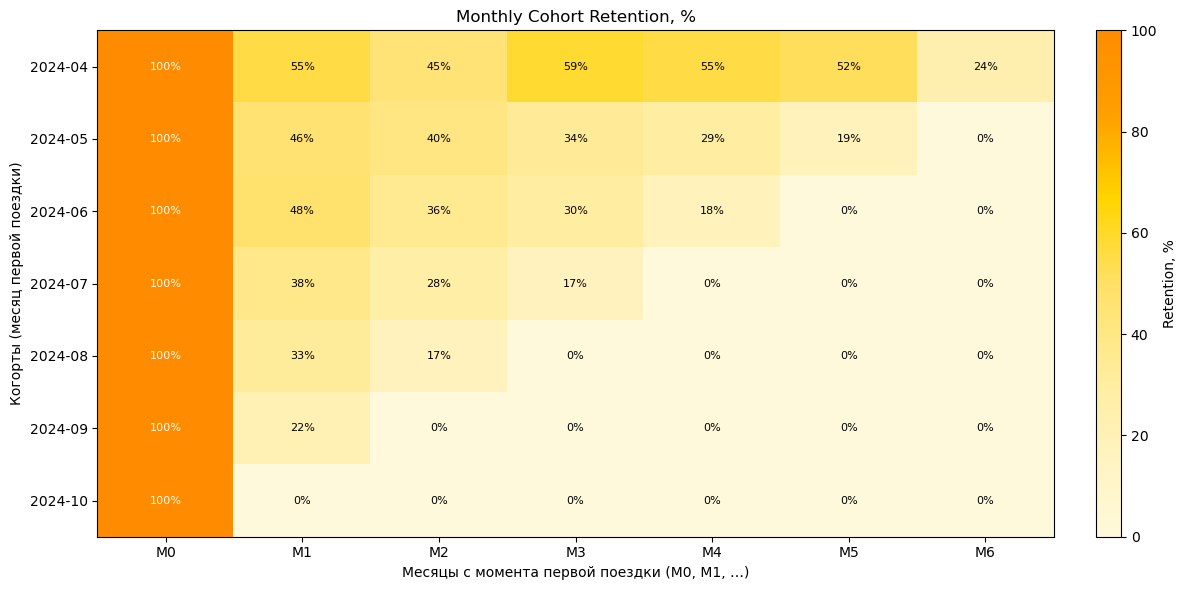

In [44]:
from matplotlib.colors import LinearSegmentedColormap

# исходная таблица retention_m из предыдущей ячейки
ret = retention_m.copy()
ret = ret.apply(pd.to_numeric, errors='coerce').sort_index().sort_index(axis=1)
if np.nanmax(ret.values) <= 1.000001:
    ret = ret * 100

# жёлто-оранжевый градиент
cmap = LinearSegmentedColormap.from_list(
    'yl_or',
    ['#FFF9DB', '#FFF3BF', '#FFEC99', '#FFE066', '#FFD500', '#FFA000', '#FF8C00'],
    N=256
)

vmax = float(np.nanmax(ret.values))
fig, ax = plt.subplots(figsize=(12, 6))
im = ax.imshow(ret.values, aspect='auto', cmap=cmap, vmin=0, vmax=vmax)

ax.set_title('Monthly Cohort Retention, %')
ax.set_xlabel('Месяцы с момента первой поездки (M0, M1, …)')
ax.set_ylabel('Когорты (месяц первой поездки)')
ax.set_xticks(range(ret.shape[1])); ax.set_xticklabels([f'M{int(c)}' for c in ret.columns])
ax.set_yticks(range(ret.shape[0])); ax.set_yticklabels([str(i) for i in ret.index])

# подписи с автоматическим выбором цвета для контраста
threshold = 0.65 * vmax
for i in range(ret.shape[0]):
    for j in range(ret.shape[1]):
        v = ret.iat[i, j]
        if np.isfinite(v):
            ax.text(j, i, f'{v:.0f}%',
                    ha='center', va='center',
                    color=('black' if v < threshold else 'white'),
                    fontsize=8)

cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Retention, %')

plt.tight_layout()
plt.show()

- По по истечении нескольких месяцев после исполььзования приложения в нём остаётся **~22%** от изначальных пользователей, **НО** наблюдается тенденция, что у каждой новой когорты количество пользователей, которые остаются после первого месяца использования приложения, падает (**с 55 до 22%**), это может быть связано с несколькими причинами ...

### Как отличаются ключевые характеристики у мужчин и женщин?

#### Расстояние, длительность и стоемость поездки:

- Попробуем проследить, есть ли различия между ключевыми харакетистиками поездок у женщин и мужчин. А именно, рассчитаем среднюю продолжительность поездки, а также расстояние и стоимость.

In [25]:
df_gender.groupby('gender_cd', observed=False)[['trip_duration_min','distance_km','nominal_price_rub_amt']].mean().round(2)

NameError: name 'df_gender' is not defined

- **Длительность поездки:** Женщины катаются в среднем дольше: **8.3 мин** против **7.8 мин** у мужчин.  
- **Дистанция поездки:** Различия минимальны: **1.69 км** у женщин против **1.77 км** у мужчин.  
- **Стоимость поездки:** У женщин средний чек выше: **106 руб.** против **101 руб.** у мужчин.  

- Можно видеть, что при том, что среднее расстояние поездки у женщин меньше чем у мужчин, у них она длиннее больше чем на пол минуты. Это может быть связано как с тем, что они более аккуратно водят, так и с тем, что они чаще катаются на самокатах с целью получить удовольствие от поездки, а не добраться от точки А до точки Б.

#### Частота поездок: 

In [ ]:
# Подготовим даныне по количеству поездок 
trips_by_user = (
    df.loc[df['gender_cd'].isin(['M','F'])]
      .groupby(['party_rk','gender_cd'], observed=True)['order_rk']
      .nunique()
      .reset_index(name='trips')
)

# Посмотрим на описательную статистику
stats = (trips_by_user
         .groupby('gender_cd', observed=True)['trips']
         .describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]))

stats

- Интересно, мы можем видеть, что у нас порядка половины клиентов не седалали больше двух поездок за 6 месяцев (и среди мужчин, и среди женщин), однако мужчины, всё таки, чаще делали поездки, как можно видеть по 3 куантилю и максимальное количество поездок у них тольже больше. 308 поездок - видимо, кто-то ездил несколько раз в день.
- Высокий показатель может быть связан с высоким кешбеком при первом пользовании сервисом даже для пользователей без подписки (см. изображение ниже, источник: https://www.tbank.ru/gorod/blog/kicksharing-news/)

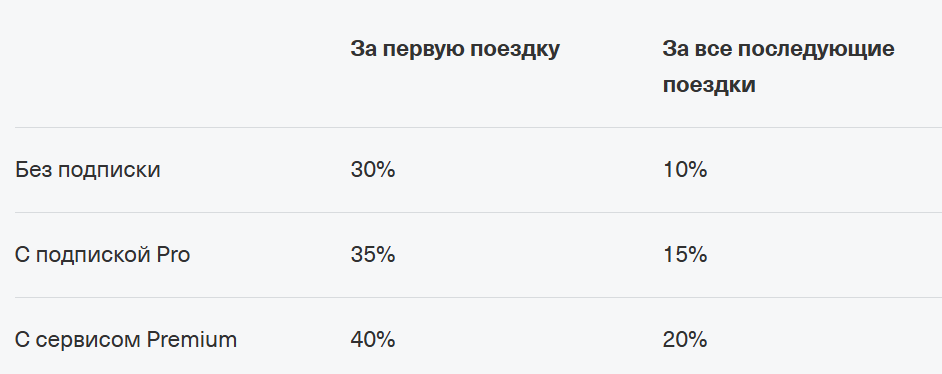

### Есть ли различия в количестве поездок в зависимости от возраста

In [39]:
# Группировка по возрастным категориям
cols = ['trip_duration_min','distance_km','nominal_price_rub_amt']

# только реально встречающиеся категории
age_stats = (df.groupby('age_group', observed=True)[cols]
               .mean()
               .round(2))

age_stats

,trip_duration_min,distance_km,nominal_price_rub_amt
age_group,,,
18–29,7.76,1.77,99.90
30–39,7.90,1.76,103.03
40–49,7.90,1.71,104.26
50+,7.60,1.65,102.05


In [42]:
# 1) Возраст пользователя (1 запись на user)
user_age = (df[['party_rk', 'age']]
            .dropna()
            .drop_duplicates('party_rk'))

# 2) Биннинг возраста: [18,30), [30,40), [40,50), [50,∞)
bins   = [18, 30, 40, 50, np.inf]
labels = ['18–29', '30–39', '40–49', '50+']
user_age['age_bin'] = pd.cut(user_age['age'], bins=bins, labels=labels, right=False)

# 3) Поездок на пользователя
trips_per_user = (df.groupby('party_rk')['order_rk']
                    .nunique()                     # если 1 строка = 1 поездка, можно .size()
                    .rename('trips')
                    .reset_index())

# 4) Сводка по возрастным бинам
trips_by_user = (trips_per_user
                 .merge(user_age[['party_rk','age_bin']], on='party_rk', how='left')
                 .dropna(subset=['age_bin']))

stats_by_age = (trips_by_user.groupby('age_bin', observed=True)['trips']
                .describe(percentiles=[0.5, 0.9])  # медиана и p90 в отчёте
                .round(2))

kpis_by_age = (trips_by_user.groupby('age_bin', observed=True)['trips']
               .agg(mean='mean', median='median', p90=lambda s: s.quantile(0.9))
               .round(2))

stats_by_age

,count,mean,std,min,50%,90%,max
age_bin,,,,,,,
18–29,23804.0,6.44,13.11,1.0,2.0,15.0,283.0
30–39,19098.0,5.99,12.78,1.0,2.0,14.0,308.0
40–49,8638.0,5.61,12.37,1.0,2.0,12.0,228.0
50+,1298.0,6.07,13.87,1.0,2.0,14.0,208.0


In [ ]:
avg_trips_per_age = avg_trips_per_age.dropna()  # уберём NaN для группы 60+
overall_mean = avg_trips_per_age.mean()

# Построение
plt.figure(figsize=(10, 4))
ax = avg_trips_per_age.plot(kind='bar', color="#FFD500", edgecolor="black")

# Горизонтальная линия среднего
plt.axhline(overall_mean, color="red", linestyle="--", linewidth=1.5, label=f"Среднее: {overall_mean:.2f}")

# Сделаем подписи, для того, чтобы упросить чтение
for i, v in enumerate(avg_trips_per_age):
    ax.text(i, v + 0.05, str(v), ha='center', va='bottom')

plt.title("Среднее количество поездок на пользователя по возрастным группам")
plt.xlabel("Возрастная группа")
plt.ylabel("Среднее количество поездок")
plt.legend()
plt.tight_layout()
plt.show()

- **<20 лет**: также ниже среднего (**5.79 поездок**). 
- **20–29 лет**: самая активная группа, в среднем **6.57 поездок на пользователя**, что значительно выше среднего уровня (**6.01**). Это может быть свяазно с тем, что в 20-30 лет большинство поездок на работу (или при проведении досуга) осуществляется в связке СИМ + ОТ, потому что сложно приобрести личный транспорт.  
- **30–39 лет**: близко к среднему, **5.99 поездок**, но наблюдается снижение среднего числа поездок в сравнении с более молодой группой, что может быть связано с тем, что с ростом дохода люди пересаживаются на личные авто и поездки на самокатах всё чаще становятся способом проведения досуга, а не средством передвижения. 
- **40–49 лет**: заметно ниже среднего — **5.61 поездки**, что делает эту группу **наименее активной**. Такой низкий уровень активности может быть связан с наличием личного авто, как было сказано ранее и тем, что люди использую самокат в первую очередь чтобы провести досуг и получить удовольствие от поездки. 
- **50–59 лет**: чуть выше среднего — **6.07 поездок**, но данный показатель сейчас нас мало интересует, потому эта аудитория не превышает и 2х процентов от общего числа пользователей.    

## ЧАСТЬ 4: Выдвижение и проверка гипотез